In [1]:
# Imports

import os
import string
import re
import html  

from collections import Counter

from nltk.text import Text

from cltk.corpus.latin import latinlibrary
from cltk.tokenize.word import WordTokenizer
from cltk.stem.latin.j_v import JVReplacer
from cltk.lemmatize.latin.backoff import BackoffLatinLemmatizer
from cltk.utils.file_operations import open_pickle

from pprint import pprint

Arabic not supported. Install `pyarabic` library to tokenize Arabic.


In [2]:
# We need to import a data model to train the lemmatizer.

# Set up training sentences
rel_path = os.path.join('~/cltk_data/latin/model/latin_models_cltk/lemmata/backoff')
path = os.path.expanduser(rel_path)

# Check for presence of latin_pos_lemmatized_sents
file = 'latin_pos_lemmatized_sents.pickle'      

latin_pos_lemmatized_sents_path = os.path.join(path, file)
if os.path.isfile(latin_pos_lemmatized_sents_path):
    latin_pos_lemmatized_sents = open_pickle(latin_pos_lemmatized_sents_path)
else:
    latin_pos_lemmatized_sents = []
    print('The file %s is not available in cltk_data' % file)  

In [3]:
# Setup CLTK tools

word_tokenizer = WordTokenizer('latin')
replacer = JVReplacer()
lemmatizer = BackoffLatinLemmatizer(latin_pos_lemmatized_sents)

In [4]:
# Get the Sallust BC text

bc = latinlibrary.raw('sall.1.txt')

# Remove LL paratexts
bc = bc[bc.find('[1] '):]
bc = bc.replace('Sallust The Latin Library The Classics Page', '')

# Split into chapters
bc_chapters = re.split("\[\d+\] ", bc)[1:]

pprint(bc_chapters[:1])

['Omnis homines, qui sese student praestare ceteris animalibus, summa ope niti '
 'decet, ne vitam silentio transeant veluti pecora, quae natura prona atque '
 'ventri oboedientia finxit. Sed nostra omnis vis in animo et corpore sita '
 'est: animi imperio, corporis servitio magis utimur; alterum nobis cum dis, '
 'alterum cum beluis commune est. Quo mihi rectius videtur ingeni quam virium '
 'opibus gloriam quaerere et, quoniam vita ipsa, qua fruimur, brevis est, '
 'memoriam nostri quam maxume longam efficere. Nam divitiarum et formae gloria '
 'fluxa atque fragilis est, virtus clara aeternaque habetur.\n'
 ' \n'
 '\n'
 ' \n'
 'Sed diu magnum inter mortalis certamen fuit, vine corporis an virtute animi '
 'res militaris magis procederet. Nam et, prius quam incipias, consulto et, '
 'ubi consulueris, mature facto opus est. Ita utrumque per se indigens alterum '
 'alterius auxilio eget.\n'
 ' \n'
 '\n'
 ' \n'
 ' ']


In [5]:
# Preprocess texts

def preprocess(text):
    
    text = html.unescape(text) # Handle html entities
    text = re.sub(r'&nbsp;?', ' ',text) #&nbsp; stripped incorrectly in corpus?
    text = re.sub(r'\x00',' ',text) #Another space problem?
    
    text = text.lower()
    text = replacer.replace(text) #Normalize u/v & i/j
        
    punctuation ="\"#$%&\'()*+,-/:;<=>@[\]^_`{|}~.?!«»—"
    translator = str.maketrans({key: " " for key in punctuation})
    text = text.translate(translator)
    
    translator = str.maketrans({key: " " for key in '0123456789'})
    text = text.translate(translator)
    
    text = re.sub('[ ]+',' ', text) # Remove double spaces
    text = re.sub('\s+\n+\s+','\n', text) # Remove double lines and trim spaces around new lines
    
    return text

In [6]:
# Preprocess chapters

bc_chapters = [preprocess(chapter).strip() for chapter in bc_chapters]
pprint(bc_chapters[:2])

['omnis homines qui sese student praestare ceteris animalibus summa ope niti '
 'decet ne uitam silentio transeant ueluti pecora quae natura prona atque '
 'uentri oboedientia finxit sed nostra omnis uis in animo et corpore sita est '
 'animi imperio corporis seruitio magis utimur alterum nobis cum dis alterum '
 'cum beluis commune est quo mihi rectius uidetur ingeni quam uirium opibus '
 'gloriam quaerere et quoniam uita ipsa qua fruimur breuis est memoriam nostri '
 'quam maxume longam efficere nam diuitiarum et formae gloria fluxa atque '
 'fragilis est uirtus clara aeternaque habetur\n'
 'sed diu magnum inter mortalis certamen fuit uine corporis an uirtute animi '
 'res militaris magis procederet nam et prius quam incipias consulto et ubi '
 'consulueris mature facto opus est ita utrumque per se indigens alterum '
 'alterius auxilio eget',
 'igitur initio reges nam in terris nomen imperi id primum fuit diuorsi pars '
 'ingenium alii corpus exercebant etiam tum uita hominum sine cu

In [7]:
# Create NLTK Text for BC

bc_words = " ".join(bc_chapters).split()
bc_text = Text(bc_words)
print(bc_text)

<Text: omnis homines qui sese student praestare ceteris animalibus...>


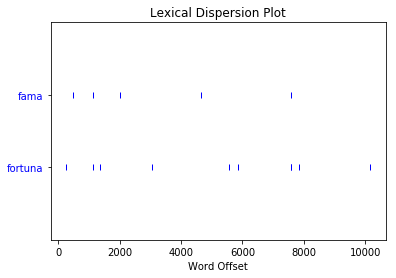

In [8]:
# Show dispersion plot for important vocabulary

bc_text.dispersion_plot(['fama','fortuna'])

In [9]:
# Lemmatize BC

bc_lemma_pairs = lemmatizer.lemmatize(bc_words)

print('This is the lemmatizer output—tuples of (token, lemma)')
print(bc_lemma_pairs[:10])

# Extract just the lemmas
bc_lemmas = [lemma[1] for lemma in bc_lemma_pairs]
print('This is a list of just lemmas.')
print(bc_lemmas[:10])

This is the lemmatizer output—tuples of (token, lemma)
[('omnis', 'omnis'), ('homines', 'homo'), ('qui', 'qui'), ('sese', 'sui'), ('student', 'studeo'), ('praestare', 'praesto'), ('ceteris', 'ceterus'), ('animalibus', 'animal'), ('summa', 'summus'), ('ope', 'ops')]
This is a list of just lemmas.
['omnis', 'homo', 'qui', 'sui', 'studeo', 'praesto', 'ceterus', 'animal', 'summus', 'ops']


In [10]:
# Create NLTK Text for lemmatized BC

bc_lemmatized_text = Text(bc_lemmas)
print(bc_lemmatized_text)

<Text: omnis homo qui sui studeo praesto ceterus animal...>


This is the unlemmatized dispersion plot.



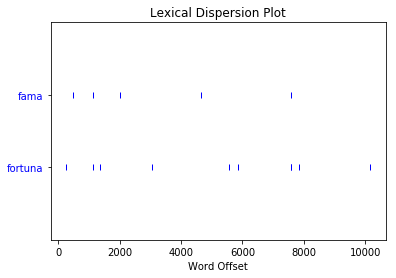


This is the lemmatized dispersion plot.



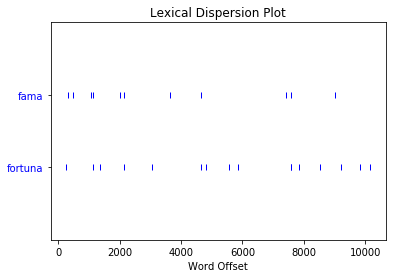

In [11]:
# Show dispersion plot for important vocabulary by lemma

print("This is the unlemmatized dispersion plot.\n")
bc_text.dispersion_plot(['fama','fortuna'])

print("\nThis is the lemmatized dispersion plot.\n")
bc_lemmatized_text.dispersion_plot(['fama','fortuna'])

In [12]:
# Some data about the fama/fortuna results

c = Counter(bc_lemmas)
print("There are %d instances of 'fama' in the Bellum catilinum." % c['fama'])
print("There are %d instances of 'fortuna' in the Bellum catilinum." % c['fortuna'])

bc_fama_tokens = set([item[0] for item in bc_lemma_pairs if item[1] == 'fama'])
bc_fortuna_tokens = set([item[0] for item in bc_lemma_pairs if item[1] == 'fortuna'])
print("\nThe following forms of fama are found in the BC:", bc_fama_tokens)
print("The following forms of fortuna are found in the BC:", bc_fortuna_tokens)

There are 11 instances of 'fama' in the Bellum catilinum.
There are 16 instances of 'fortuna' in the Bellum catilinum.

The following forms of fama are found in the BC: {'famam', 'famae', 'fama'}
The following forms of fortuna are found in the BC: {'fortunae', 'fortunas', 'fortuna', 'fortunis', 'fortunam'}



          Dispersion plot of catlina/cicero
      in Sallust's Bellum catilinum (lemmatized)


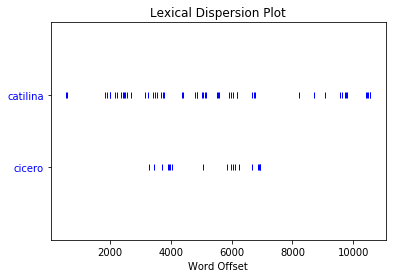

In [13]:
# Show dispersion plot for important vocabulary by lemma—another example

print("\n          Dispersion plot of catlina/cicero\n      in Sallust's Bellum catilinum (lemmatized)")

bc_lemmatized_text.dispersion_plot(['catilina','cicero'])

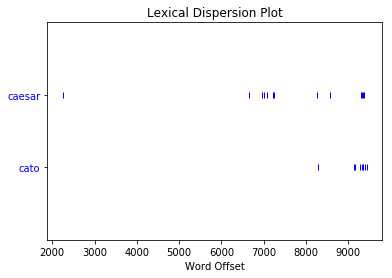

In [14]:
# Show dispersion plot for important vocabulary by lemma—another example

bc_lemmatized_text.dispersion_plot(['caesar','cato'])